# 1.2 données temporelles

### 1.2.1 prétraitement 

In [2]:
import numpy as np
import pandas as pd
import re
from datetime import datetime
import statistics
import math
import random
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

In [3]:
def convert_date(time_period, date, year_mapping):
    date = str(date)
    dd_mm_yy = re.compile(r'\b\d{1,2}/\d{1,2}/\d{4}\b')
    dd_mmm = re.compile(r'\b\d{1,2}-[a-zA-Z]{3}\b')

    if dd_mm_yy.match(date):
        input_date = datetime.strptime(date, '%m/%d/%Y')
        formatted_date = input_date.strftime('%m/%d/%Y')
        return np.datetime64(datetime.strptime(formatted_date, '%m/%d/%Y'))
    elif dd_mmm.match(date):
        day, month = date.split('-')
        month_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
        month = month_dict[month]
        for interval, y in year_mapping.items():
            if interval[0] <= int(time_period) <= interval[1]:
                year = y
                break
        return np.datetime64(datetime(int(year), month, int(day)))
    else:
        return None

In [4]:
datas=pd.read_csv('Dataset2.csv')
pd.DataFrame(datas).head()
datas = datas.replace({pd.NA: np.nan})
dataset2 = datas.to_numpy()

numeric_columns = datas.select_dtypes(include=['int', 'float']).columns.tolist()
numeric_columns = [datas.columns.get_loc(col) for col in numeric_columns]

print(numeric_columns)
print("Types des différents attributs : ", [type(att) for att in dataset2[0, :]])
print(dataset2[:10])

[0, 1, 2, 5, 6, 7, 8, 9, 10]
Types des différents attributs :  [<class 'int'>, <class 'int'>, <class 'int'>, <class 'str'>, <class 'str'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
[[95129 32 39741 '10/11/2020' '10/31/2020' 22.0 2543.0 23.0 2.6 304.7 0.9]
 [95129 43 39741 '5/30/2021' '6/19/2021' nan 3315.0 14.0 1.1 397.2 0.4]
 [95129 40 39741 '3/28/2021' '4/17/2021' 34.0 4816.0 37.0 4.1 577.1 0.8]
 [95129 55 39741 '2/6/2022' '2/26/2022' 110.0 10194.0 175.0 13.2 1221.5
  1.7]
 [95129 44 39741 '6/20/2021' '7/10/2021' 14.0 3033.0 17.0 1.7 363.4 0.6]
 [95129 54 39741 '1/16/2022' '2/5/2022' 624.0 13479.0 817.0 74.8 1615.1
  6.1]
 [95129 25 39741 '5/17/2020' '6/6/2020' nan 762.0 nan 0.4 91.3 0.4]
 [95129 30 39741 '8/30/2020' '9/19/2020' 20.0 1773.0 20.0 2.4 212.4 1.1]
 [95129 31 39741 '9/20/2020' '10/10/2020' 12.0 2120.0 12.0 1.4 254.0 0.6]
 [95129 66 39741 '9/25/2022' '10/15/2022' 66.0 1571.0 78.0 7.9 188.2 5.0]]


In [5]:
dataset = dataset2

In [6]:
df = datas

df['Start date'] = pd.to_datetime(df['Start date'], errors='coerce')
df['end date'] = pd.to_datetime(df['end date'], errors='coerce')

yearly_intervals = df.groupby((df['Start date'].dt.year))['time_period'].agg(['min', 'max'])
print(yearly_intervals)
year_mapping = {}

for year, interval in yearly_intervals.iterrows():
    year_mapping[(interval['min'], interval['max'])] = int(year)

print(year_mapping)

for row in dataset:
    row[3] = convert_date(row[1], row[3], year_mapping)
    row[4] = convert_date(row[1], row[4], year_mapping)

print(dataset[:, 3:5])

            min  max
Start date          
2019.0       18   18
2020.0       19   35
2021.0       36   53
2022.0       54  155
{(18, 18): 2019, (19, 35): 2020, (36, 53): 2021, (54, 155): 2022}
[[numpy.datetime64('2020-10-11T00:00:00.000000')
  numpy.datetime64('2020-10-31T00:00:00.000000')]
 [numpy.datetime64('2021-05-30T00:00:00.000000')
  numpy.datetime64('2021-06-19T00:00:00.000000')]
 [numpy.datetime64('2021-03-28T00:00:00.000000')
  numpy.datetime64('2021-04-17T00:00:00.000000')]
 [numpy.datetime64('2022-02-06T00:00:00.000000')
  numpy.datetime64('2022-02-26T00:00:00.000000')]
 [numpy.datetime64('2021-06-20T00:00:00.000000')
  numpy.datetime64('2021-07-10T00:00:00.000000')]
 [numpy.datetime64('2022-01-16T00:00:00.000000')
  numpy.datetime64('2022-02-05T00:00:00.000000')]
 [numpy.datetime64('2020-05-17T00:00:00.000000')
  numpy.datetime64('2020-06-06T00:00:00.000000')]
 [numpy.datetime64('2020-08-30T00:00:00.000000')
  numpy.datetime64('2020-09-19T00:00:00.000000')]
 [numpy.datetime

## traitement des val manquantes


In [7]:
def mode(data_column):
    freq = {}
    max_freq = 0
    modes = []

    for val in data_column:
        if not np.isnan(val):
            if val in freq:
                freq[val] += 1
            else:
                freq[val] = 1
                
            if freq[val] > max_freq:
                max_freq = freq[val]
                modes = [val]
            elif freq[val] == max_freq:
                modes.append(val)

    return modes

print(dataset[6])

def replace_missing_values(method, attribut):
    missing = [i for i, val in enumerate(dataset[:, attribut]) if np.isnan(val)]

    for i in missing:
        if method == "Mode":
            modes = mode(dataset[:, attribut])
            dataset[i, attribut] = np.random.choice(modes, size=1)[0]
        else:
            zone = dataset[i, 0]
            zone_rows = [z for z in range(dataset.shape[0]) if dataset[z, 0]==zone and not np.isnan(dataset[z, attribut])]
            mean_val = np.mean(dataset[zone_rows, attribut])
            dataset[i, attribut] = mean_val

def replace_missing_values_general(method):
    for attribute_index in numeric_columns:
        replace_missing_values(method, attribute_index)

replace_missing_values_general("Moyenne")
print(dataset[6])

[95129 25 39741 numpy.datetime64('2020-05-17T00:00:00.000000')
 numpy.datetime64('2020-06-06T00:00:00.000000') nan 762.0 nan 0.4 91.3 0.4]
[95129 25 39741 numpy.datetime64('2020-05-17T00:00:00.000000')
 numpy.datetime64('2020-06-06T00:00:00.000000') 148.5609756097561 762.0
 171.07142857142858 0.4 91.3 0.4]


## traitement des val aberrantes

In [8]:
#traitement des valeurs aberrantes
def mediane(dataset):
     n = len(dataset)
     # trier les valeurs 
     dataset = sorted(dataset)
     #verifier si on a un nombre paire ou impaire de valeurs 
     if n % 2 == 0:
          return (dataset[(n // 2) - 1] + dataset[n // 2]) / 2
     else:
          return dataset[n // 2]
     
def quartiles(dataset):
    dataset = sorted(dataset)
    n = len(dataset)
    q0 = dataset[0]
    q2 = mediane(dataset)
    q4 = dataset[n - 1]

    if n % 2 == 0:
        q1 = (dataset[(n // 2) // 2 - 1] + dataset[(n // 2 // 2)]) / 2    
        q3 = (dataset[3 * (n // 2) // 2 - 1] + dataset[3 * (n // 2) // 2]) / 2
    else:
        q1 = dataset[n // 4]
        q3 = dataset[n * 3 // 4]

    return q0, q1, q2, q3, q4


In [9]:
from sklearn import linear_model
np.random.seed(42)

def Discretisation1(attribut):
    global dataset
    vals=dataset[:,attribut].copy()
    vals.sort()
    q = 1+(10/3)*np.log10(dataset.shape[0])
    nbrelmt=math.ceil(dataset[:,attribut].shape[0]/q)

    for  val in range(0,dataset[:,attribut].shape[0]):
        for i in range(0,vals.shape[0],nbrelmt):
            if(vals[i]>dataset[val,attribut]):
                sup=i
                break
        dataset[val,attribut]=np.mean(vals[sup-nbrelmt:sup])


def replace_outliers(method,attribut):
    abberante=[]

    if method=='Linear Regression':
        col = dataset[:, attribut]
        IQR=(np.percentile(col, 75)-np.percentile(col, 25))*1.5
        for i in range(0,len(col)):
            if (dataset[i,attribut] >(np.percentile(col, 75)+IQR) or dataset[i,attribut]<(np.percentile(col, 25)-IQR)):
                abberante.append(i)
    
        X = np.delete(dataset, attribut, axis=1)
        X = np.delete(X, abberante, axis=0)
        y=dataset[:,attribut]
        y= np.delete(y, abberante, axis=0).reshape(-1, 1)
        model = linear_model.LinearRegression().fit(X, y)
         
        for i in abberante:
            x2=np.delete(dataset, attribut, axis=1)
            X_new =x2[i,:].T.reshape(1, -1)
            dataset[i,attribut]=model.predict(X_new)[0][0]

    else:
        #discretisation
         Discretisation1(attribut)

def replace_outliers_general(method):
    for attribute_index in numeric_columns:
        replace_outliers(method, attribute_index)

print(dataset[48, 1])

replace_outliers_general("Linear Regression")

print(dataset[48, 1])

print(dataset[:10])

print(np.unique(dataset[:, 0]))
print(np.unique(dataset[:, 2]))



155
55.0
[[95129 32 39741 numpy.datetime64('2020-10-11T00:00:00.000000')
  numpy.datetime64('2020-10-31T00:00:00.000000') 22.0 2543.0 23.0 2.6
  304.7 0.9]
 [95129 43 39741 numpy.datetime64('2021-05-30T00:00:00.000000')
  numpy.datetime64('2021-06-19T00:00:00.000000') 148.5609756097561 3315.0
  14.0 1.1 397.2 0.4]
 [95129 40 39741 numpy.datetime64('2021-03-28T00:00:00.000000')
  numpy.datetime64('2021-04-17T00:00:00.000000') 34.0 4816.0 37.0 4.1
  577.1 0.8]
 [95129 55 39741 numpy.datetime64('2022-02-06T00:00:00.000000')
  numpy.datetime64('2022-02-26T00:00:00.000000') 110.0 10194.0 175.0 13.2
  969.6552844227372 1.7]
 [95129 44 39741 numpy.datetime64('2021-06-20T00:00:00.000000')
  numpy.datetime64('2021-07-10T00:00:00.000000') 14.0 3033.0 17.0 1.7
  363.4 0.6]
 [95129 54 39741 numpy.datetime64('2022-01-16T00:00:00.000000')
  numpy.datetime64('2022-02-05T00:00:00.000000') 547.9254693255108
  14243.717707514894 666.3682368162782 56.75184307483897
  1434.7601248929755 6.1]
 [95129 25 39

## PLOTS

In [10]:
header = ['zcta', 'time_period', 'population', 'Start date', 'end date', 'case count', 'test count', 'positive tests', 'case rate', 'test rate', 'positivity rate']
df = pd.DataFrame(dataset, columns=header)

In [11]:
grouped_df = df.groupby('zcta')

# use the 'size' function to count the number of rows for each unique zcta
size_df = grouped_df.size()

# convert the result to a dataframe
result_df = size_df.reset_index(name='Number of Rows')

# print the result dataframe
print(result_df)

    zcta  Number of Rows
0  94085              49
1  94086              49
2  94087              48
3  95035              47
4  95127              48
5  95128              48
6  95129              48


    zcta    case count positive tests
0  94085   5555.051872    6742.748357
1  94086   7844.881867    9445.369215
2  94087   7710.415054    8969.059377
3  95035  11214.676229   13167.670784
4  95127  14512.325401   18084.855868
5  95128   9082.601541   10810.662921
6  95129   6917.112614    8012.257678


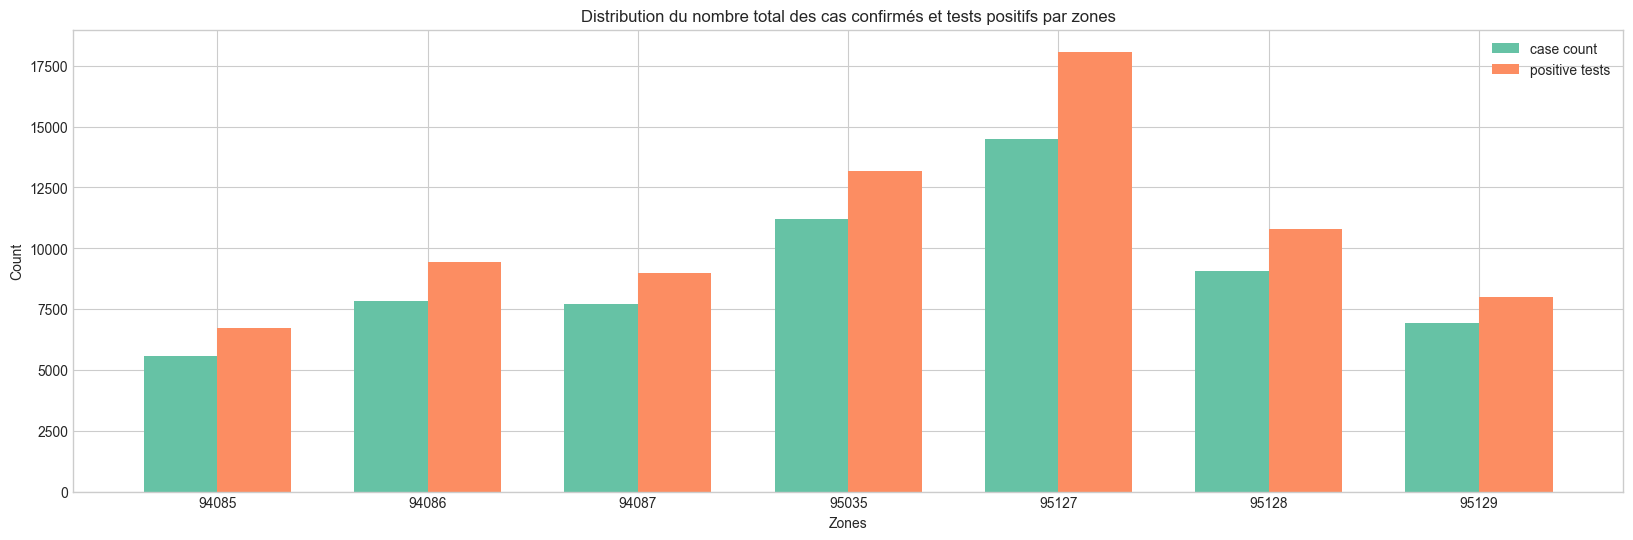

In [12]:
def plot_total_cases_and_positive_tests():
    totals = df.groupby('zcta')[['case count', 'positive tests']].sum().reset_index()
    zones = totals['zcta'].tolist()
    print(totals)

    fig, ax = plt.subplots(figsize=(20, 6))

    bar_width = 0.35
    index = range(len(zones))

    bar1 = ax.bar(index, totals['case count'], bar_width, label='case count')
    bar2 = ax.bar([i + bar_width for i in index], totals['positive tests'], bar_width, label='positive tests')

    ax.set_xlabel('Zones')
    ax.set_ylabel('Count')
    ax.set_title('Distribution du nombre total des cas confirmés et tests positifs par zones')
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(zones)
    ax.legend()

    plt.show()

    return plt
plot_total_cases_and_positive_tests()




def plot_total_cases_and_positive_tests_treemap():
    totals = df.groupby('zcta')[['case count', 'positive tests']].sum().reset_index()
    zones = totals['zcta'].tolist()

    fig = px.treemap(totals, path=['zcta'], values='case count', title='Total Case Count by ZCTA')
    fig.show()

    fig = px.treemap(totals, path=['zcta'], values='positive tests', title='Total Positive Tests by ZCTA')
    fig.show()


plot_total_cases_and_positive_tests_treemap()



The most frequent month for the chosen zone is: 2021
    test count case count positive tests Start date   end date
262     6882.0      150.0          179.0 2021-08-22 2021-09-11
266     5524.0      104.0          114.0 2021-08-01 2021-08-21


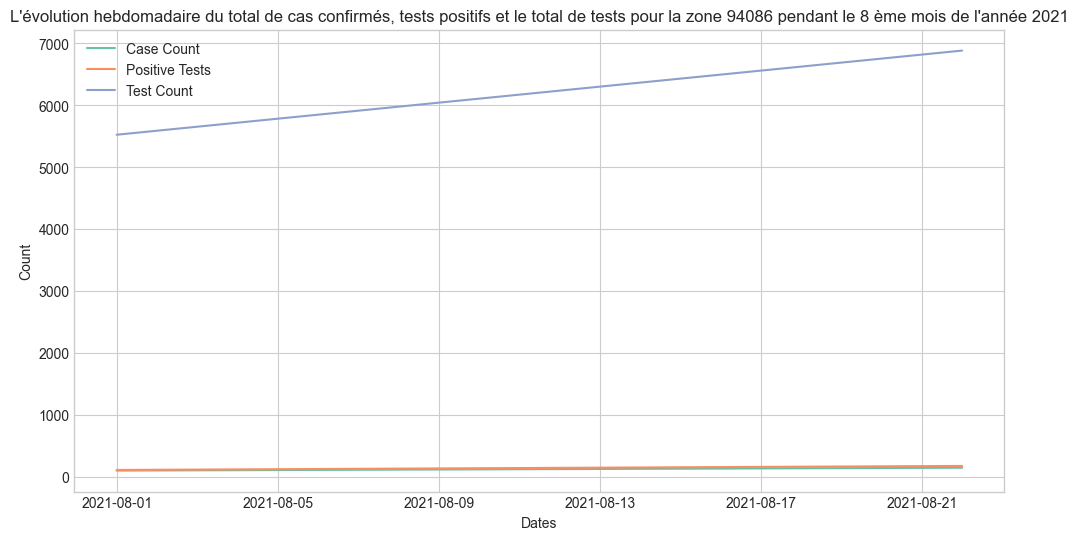

   test count   case count positive tests
0     12780.0        531.0          601.0
1      5461.0         75.0           88.0
2     11383.0        103.0          131.0
3      5270.0         55.0           68.0
4      7803.0        192.2     231.840909
5      3025.0         19.0           21.0
6      3834.0         75.0           90.0
7     12406.0        254.0          293.0
8      7362.0         48.0           66.0
9     13343.0         97.0          117.0
10     6659.0         58.0           72.0
11    18249.0  1111.389576    1385.979974


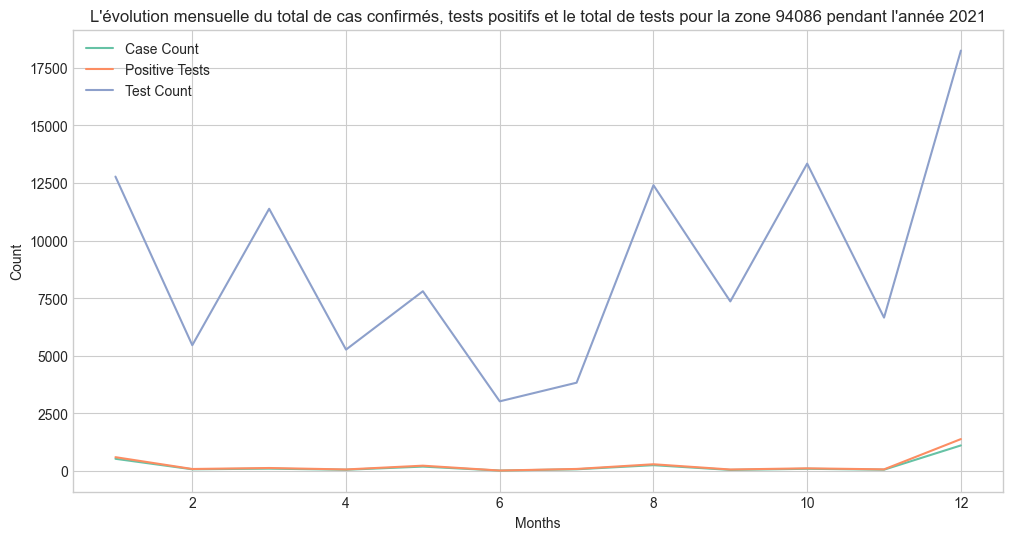

   Year   case count positive tests    test count
0  2019          0.0     204.840909   4411.913043
1  2020       1677.6    1943.522727  45304.826087
2  2021  2618.589576    3164.820883      107575.0
3  2022  3548.692291    4132.184696       58892.0


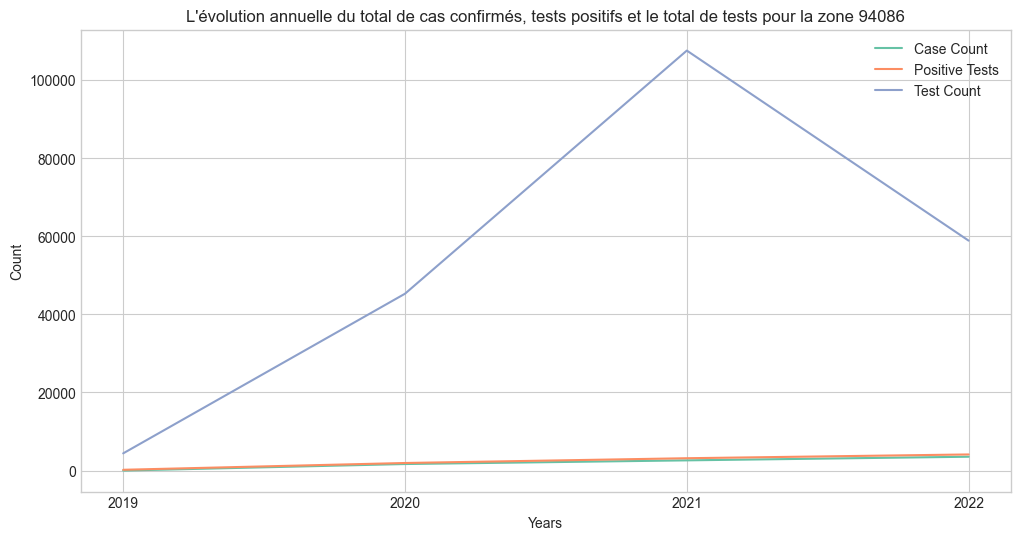

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_data_general(chosen_zone, chosen_year, chosen_month):
    
    df['Start date'] = pd.to_datetime(df['Start date'])
    df['end date'] = pd.to_datetime(df['end date'])

    df['Month'] = df['Start date'].dt.month
    df['Year'] = df['Start date'].dt.year

    zone_df = df[df['zcta'] == chosen_zone]

    most_frequent_month = zone_df['Year'].value_counts().idxmax()
    print("The most frequent month for the chosen zone is:", most_frequent_month)

    # Visualisation hebdomadaire
    plt.figure(figsize=(12, 6))
    hebdo_df = zone_df[(zone_df['Month'] == chosen_month) & (zone_df['Year'] == chosen_year)]
    print(hebdo_df[['test count', 'case count', 'positive tests', 'Start date', 'end date']])


    sns.lineplot(x='Start date', y='case count', data=hebdo_df, label='Case Count')
    sns.lineplot(x='Start date', y='positive tests', data=hebdo_df, label='Positive Tests')
    sns.lineplot(x='Start date', y='test count', data=hebdo_df, label='Test Count')
    plt.title(f'L\'évolution hebdomadaire du total de cas confirmés, tests positifs et le total de tests pour la zone {chosen_zone} pendant le {chosen_month} ème mois de l\'année {chosen_year}')
    plt.xlabel('Dates')
    plt.ylabel('Count') 
    plt.legend()
    plt.show()

    # Visualisation mensuelle
    plt.figure(figsize=(12, 6))
    monthly_df = zone_df[zone_df['Year'] == chosen_year]
    month_df = monthly_df.groupby('Month')[['case count', 'positive tests', 'test count']].sum().reset_index()
    print(month_df[['test count', 'case count', 'positive tests']])

    sns.lineplot(x='Month', y='case count', data=month_df, label='Case Count')
    sns.lineplot(x='Month', y='positive tests', data=month_df, label='Positive Tests')
    sns.lineplot(x='Month', y='test count', data=month_df, label='Test Count')    
    plt.title(f'L\'évolution mensuelle du total de cas confirmés, tests positifs et le total de tests pour la zone {chosen_zone} pendant l\'année {chosen_year}')
    plt.xlabel('Months')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    # Visualisation annuelle
    plt.figure(figsize=(12, 6))
    annual_df = zone_df.groupby('Year')[['case count', 'positive tests', 'test count']].sum().reset_index()
    annual_df['Year'] = annual_df['Year'].astype(int)
    print(annual_df)
    
    sns.lineplot(x='Year', y='case count', data=annual_df, label='Case Count')
    sns.lineplot(x='Year', y='positive tests', data=annual_df, label='Positive Tests')
    sns.lineplot(x='Year', y='test count', data=annual_df, label='Test Count')
    plt.title(f'L\'évolution annuelle du total de cas confirmés, tests positifs et le total de tests pour la zone {chosen_zone}')
    plt.xlabel('Years')
    plt.ylabel('Count')
    plt.xticks(annual_df['Year'])
    plt.legend()
    plt.show()
    

visualize_data_general(chosen_zone=94086, chosen_year=2021, chosen_month=8)


The most frequent month for the chosen zone is: 8


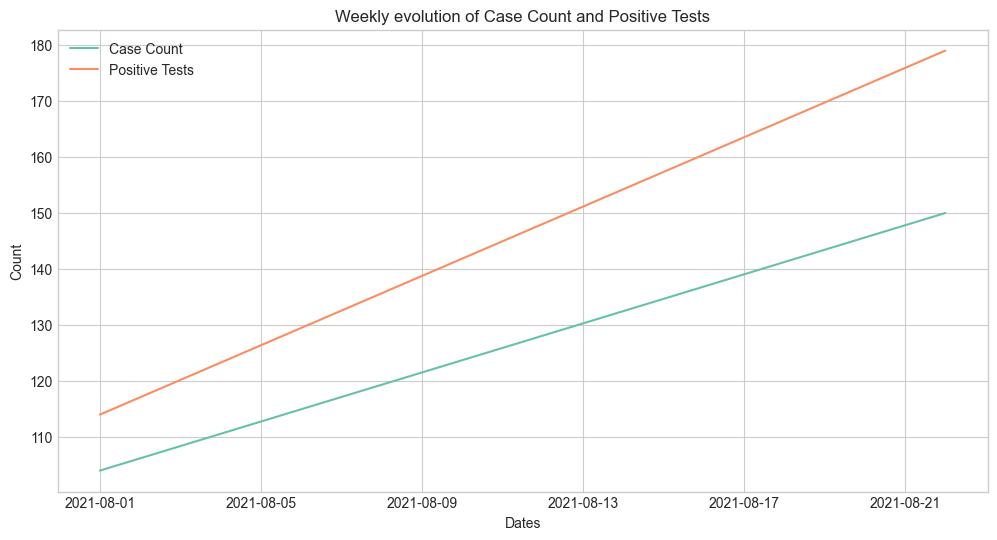

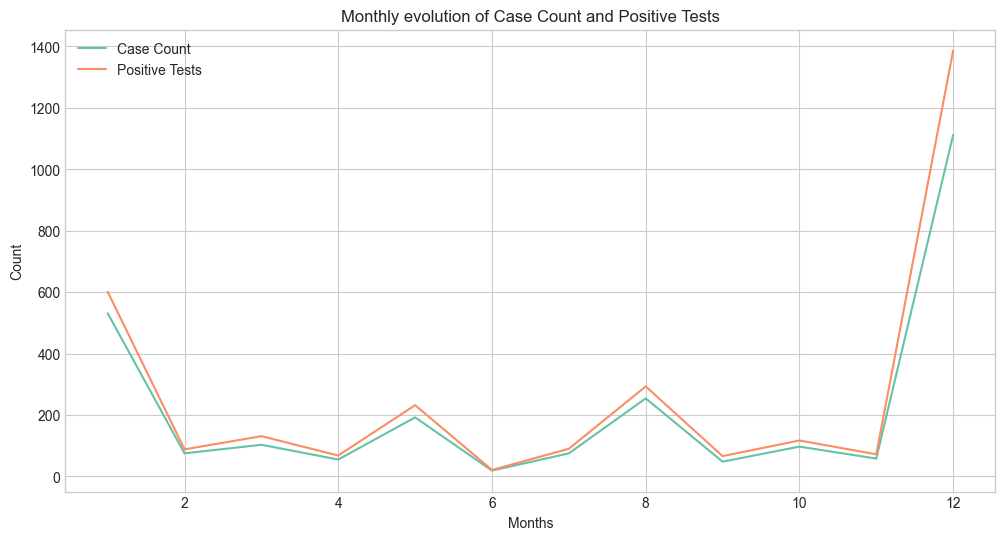

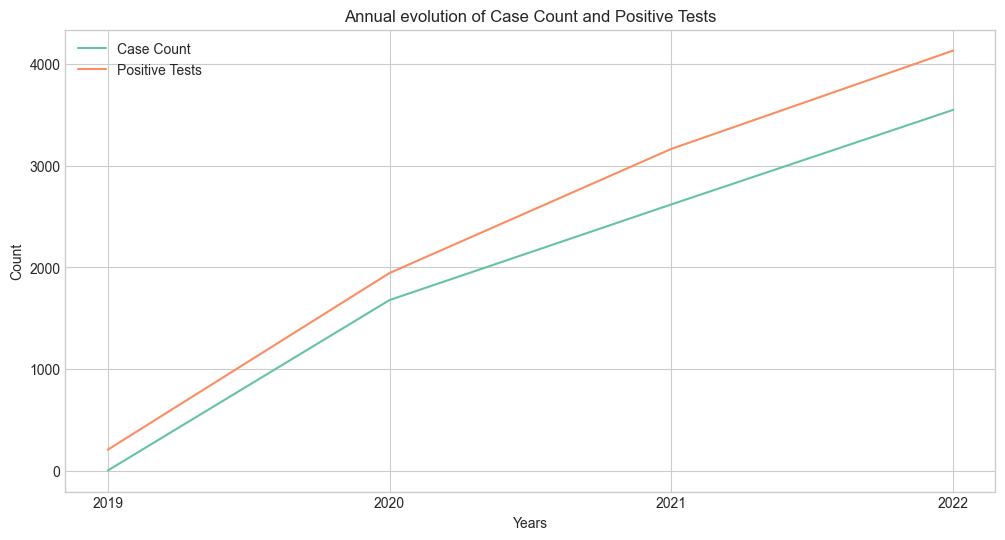

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_data(chosen_zone, chosen_year, chosen_month):
    df['Start date'] = pd.to_datetime(df['Start date'])
    df['end date'] = pd.to_datetime(df['end date'])

    df['Month'] = df['Start date'].dt.month
    df['Year'] = df['Start date'].dt.year

    zone_df = df[df['zcta'] == chosen_zone]

    most_frequent_month = zone_df['Month'].value_counts().idxmax()
    print("The most frequent month for the chosen zone is:", most_frequent_month)

    # Visualisation hebdomadaire
    plt.figure(figsize=(12, 6))
    hebdo_df = zone_df[(zone_df['Month'] == chosen_month) & (zone_df['Year'] == chosen_year)]

    sns.lineplot(x='Start date', y='case count', data=hebdo_df, label='Case Count')
    sns.lineplot(x='Start date', y='positive tests', data=hebdo_df, label='Positive Tests')
    plt.title('Weekly evolution of Case Count and Positive Tests')
    plt.xlabel('Dates')
    plt.ylabel('Count') 
    plt.legend()
    plt.show()

    # Visualisation mensuelle
    plt.figure(figsize=(12, 6))
    monthly_df = zone_df[zone_df['Year'] == chosen_year]
    month_df = monthly_df.groupby('Month')[['case count', 'positive tests']].sum().reset_index()

    sns.lineplot(x='Month', y='case count', data=month_df, label='Case Count')
    sns.lineplot(x='Month', y='positive tests', data=month_df, label='Positive Tests')
    plt.title('Monthly evolution of Case Count and Positive Tests')
    plt.xlabel('Months')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    # Visualisation annuelle
    plt.figure(figsize=(12, 6))
    annual_df = zone_df.groupby('Year')[['case count', 'positive tests']].sum().reset_index()
    annual_df['Year'] = annual_df['Year'].astype(int)

    sns.lineplot(x='Year', y='case count', data=annual_df, label='Case Count')
    sns.lineplot(x='Year', y='positive tests', data=annual_df, label='Positive Tests')
    plt.title('Annual evolution of Case Count and Positive Tests')
    plt.xlabel('Years')
    plt.ylabel('Count')
    plt.xticks(annual_df['Year'])
    plt.legend()
    plt.show()

visualize_data(chosen_zone=94086, chosen_year=2021, chosen_month=8)


zcta        94085        94086        94087        95035        95127  \
Year                                                                    
2019          0.0          0.0          NaN          NaN          0.0   
2020       1215.5       1677.6  1371.909091  2358.437665  3773.587321   
2021  2385.551872  2618.589576  2650.620688  3980.114032   5729.61876   
2022       1954.0  3548.692291  3687.885275  4876.124533  5009.119321   

zcta        95128        95129  
Year                            
2019          0.0          NaN  
2020  2111.850139  1404.804878  
2021    3324.6066  2336.229308  
2022  3646.144802  3176.078429  


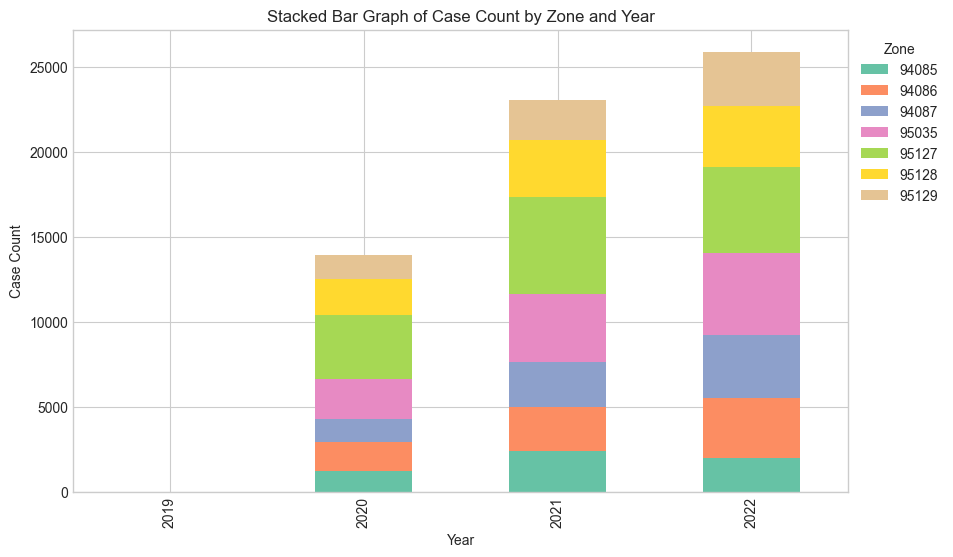

In [15]:
def plot_stacked_bar(df):
    df['Month'] = df['Start date'].dt.month
    df['Year'] = df['Start date'].dt.year

    grouped_data = df.groupby(['Year', 'zcta'])['case count'].sum().unstack()
    print(grouped_data)

    ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))
    
    ax.set_title('Stacked Bar Graph of Case Count by Zone and Year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Case Count')
    ax.legend(title='Zone', loc='upper left', bbox_to_anchor=(1, 1))


    plt.show()

plot_stacked_bar(df)


   population     test count
0       23223   104472.26087
1       36975  200285.217391
2       39741  215258.978577
3       50477   216183.73913
4       56668  292250.056416
5       66256    274327.8166
6       79655  306485.759829


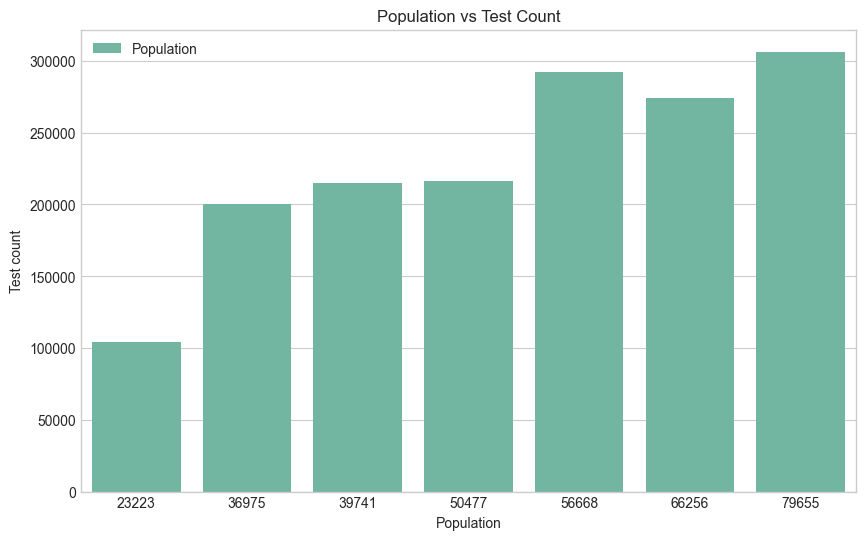

In [19]:
def plot_population_test_relation():
    data = df[['population', 'test count']]
    grouped_data = data.groupby('population').sum().reset_index()
    print(grouped_data)
    plt.figure(figsize=(10, 6))
    sns.barplot(y='test count', x='population', data=grouped_data, label='Population')
    plt.title('Population vs Test Count')
    plt.xlabel('Population')
    plt.ylabel('Test count')
    plt.show()


plot_population_test_relation()


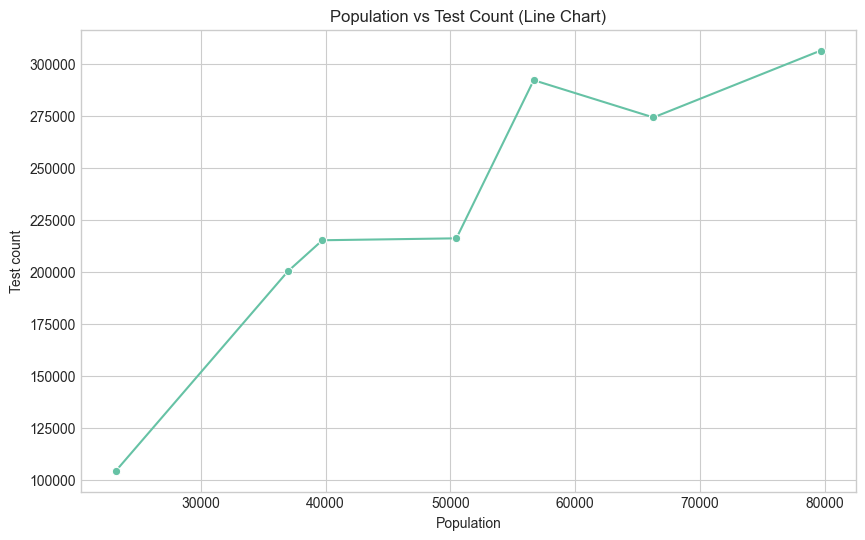

In [23]:
def plot_population_test_relation_line():
    data = df[['population', 'test count']]
    grouped_data = data.groupby('population').sum().reset_index()
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='population', y='test count', data=grouped_data, marker='o')
    plt.title('Population vs Test Count (Line Chart)')
    plt.xlabel('Population')
    plt.ylabel('Test count')
    plt.show()

plot_population_test_relation_line()


zcta
94085    5555.051872
95129    6917.112614
94087    7710.415054
94086    7844.881867
95128    9082.601541
Name: case count, dtype: object


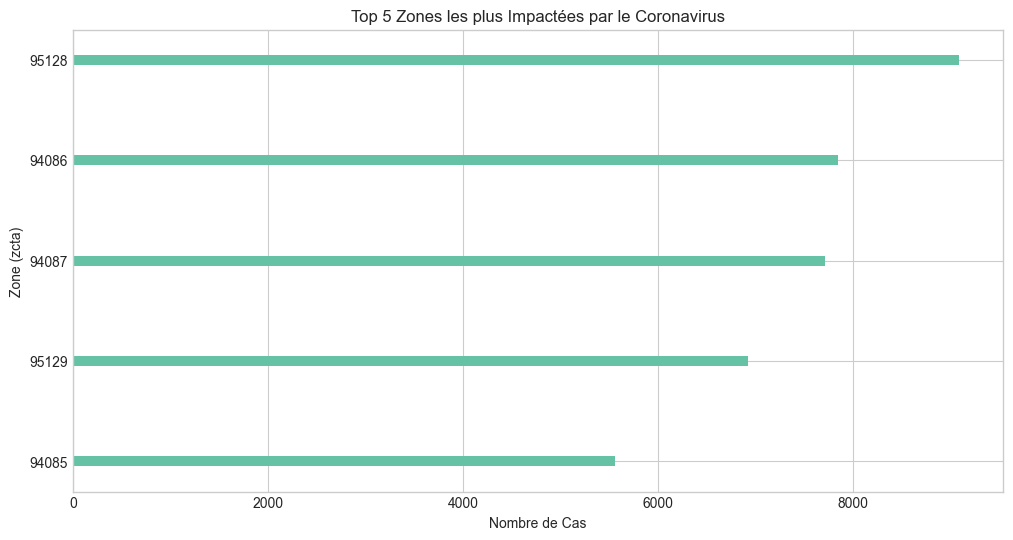

In [17]:
def plot_top_zones_impacted_matplotlib(n):
    grouped_data = df.groupby('zcta')['case count'].sum().sort_values(ascending=True).head(n)
    print(grouped_data)

    bar_width = 0.1

    grouped_data.plot.barh(figsize=(12, 6), width=bar_width)


    # Add labels and title
    plt.title(f'Top {n} Zones les plus Impactées par le Coronavirus')
    plt.xlabel('Nombre de Cas')
    plt.ylabel('Zone (zcta)')

    # Show the plot
    plt.show()
plot_top_zones_impacted_matplotlib(5)


    zcta positive tests test count case count
0  94085           29.0     1871.0       24.0
1  94086           55.0     3675.0       47.0
2  94087      34.811942     4371.0       19.0
3  95035           85.0     5091.0       77.0
4  95127          202.0     4586.0      172.0
5  95128           55.0     3560.0       42.0
6  95129           23.0     2543.0       22.0


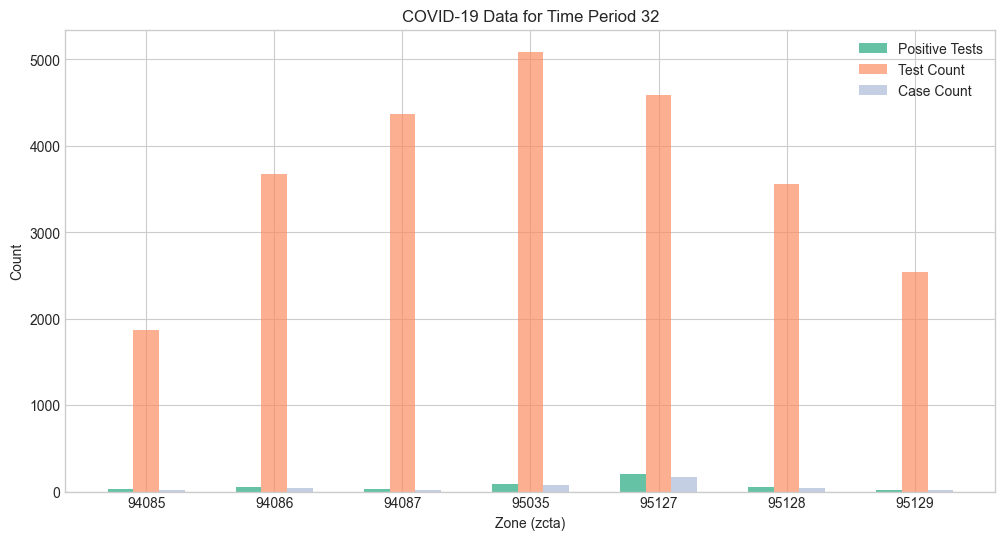

In [18]:
def plot_covid19_data(time_period):

    selected_data = df[(df['time_period'] == time_period)]

    grouped_data = selected_data.groupby('zcta')[['positive tests', 'test count', 'case count']].sum().reset_index()

    fig, ax = plt.subplots(figsize=(12, 6))

    bar_width = 0.2
    index = grouped_data.index
    print(grouped_data)

    ax.bar(index - bar_width, grouped_data['positive tests'], width=bar_width, label='Positive Tests')
    ax.bar(index, grouped_data['test count'], width=bar_width, label='Test Count', alpha=0.7)
    ax.bar(index + bar_width, grouped_data['case count'], width=bar_width, label='Case Count', alpha=0.5)

    ax.set_xticks(index)
    ax.set_xticklabels(grouped_data['zcta'])
    ax.set_xlabel('Zone (zcta)')
    ax.set_ylabel('Count')
    ax.set_title(f'COVID-19 Data for Time Period {time_period}')
    ax.legend()

    plt.show()

plot_covid19_data(32)  
